## PRIZM Analysis Pipeline

In [2]:
import importlib
import sys
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from data_prep import DataPrep
from rfi_flagging import RFI_flagging
import helper_functions as hf
from gsm_data import GSMData, get_desired_frequencies

In [35]:
_ = importlib.reload(sys.modules['gsm_data'])
_ = importlib.reload(sys.modules['helper_functions'])
import helper_functions as hf
from gsm_data import GSMData, get_desired_frequencies

#### Load Data & GSM

If uploading data from saved NumPy files:

In [69]:
instrument = '100MHz'
year = '2021'

channel = 'EW'

# times
path2file = f'../Data/{year}/{instrument[:-3]}/{channel}/'
file_ending = f'_{year}_{instrument[:-3]}{channel}.npy'

with open(path2file + 'lst' + file_ending, 'rb') as f:
    lst = np.load(f)
with open(path2file + 'systime' + file_ending, 'rb') as f:
    systime = np.load(f)

    
channel = 'NS'

# rfi flagged data & freq
with open(f'RFI_flagged/rfi_flagged_{instrument[:-3]}{channel}.npz', 'rb') as f:
    data_file = np.load(f)
    data = data_file['data']
    freq = data_file['freq']

# gsm
Tgsm = np.load(f'GSM_averages/{instrument}_{channel}_GSM_average_2minbins_horizon_0align.npy')
TgsmH = np.load(f'GSM_averages/{instrument}_{channel}_Haslam255_average_2minbins_horizon_0align.npy')

#### Binning

In [5]:
binsize_f = 1
binsize_t = 2
flow = 52
fhigh = 134
data_binned, freq_1mhz, lst_2min, bin_inds_f, bin_inds_t = hf.binning(data, freq, lst, binsize_f, binsize_t, flow, fhigh)

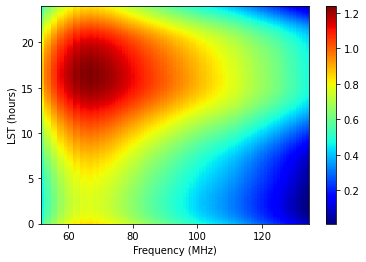

In [6]:
plt.figure()
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.pcolormesh(freq_1mhz, lst_2min, 
               np.log10(data_binned), cmap='jet', shading='nearest')
plt.colorbar()
plt.show()

# GSM calibration

In [7]:
gsm_flow = 30

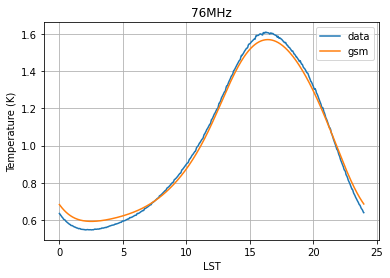

In [81]:
f = 70

fig = plt.figure()
ax = fig.subplots(1,1)
ax.grid()
ax.set_title('76MHz')
ax.set_ylabel('Temperature (K)')
ax.set_xlabel('LST')
ax.plot(lst_2min, data_binned[:, (f - flow)] / np.mean(data_binned[:, (f - flow)]), \
           label='data')
ax.plot(lst_2min, Tgsm[(np.arange(720)+10)%720, (f - gsm_flow)//2] / np.mean(Tgsm[(np.arange(720)+10)%720, (f - gsm_flow)//2]), \
           label='gsm')
ax.legend()

In [94]:
# Tgsm_c = Tgsm[(np.arange(720)+10)%720, (flow-gsm_flow)//2:(fhigh-gsm_flow)//2 + 1]
Tgsm_c = Tgsm[:, (flow-gsm_flow)//2:(fhigh-gsm_flow)//2 + 1]
krat = Tgsm_c / data_binned[:, ::2]
x = freq_1mhz[::2]

### SVD

In [95]:
# bone = np.ones((krat.shape[0],krat.shape[1]))
n = krat.shape[0]
r = np.linalg.matrix_rank(krat)
U, σ, VH = np.linalg.svd(krat, full_matrices=True)
# V = VH.T

# sigma_inv = np.vstack([np.diag(1/σ), np.zeros((n-r,r))])
sigma = np.vstack([np.diag(σ), np.zeros((n-r,r))])
# V1=V[:,0:r] 
# Sr=sigma_inv[0:r,0:r]
# U1=U[:,0:r]

# xk = V1 @ Sr @ U1.T @ bone

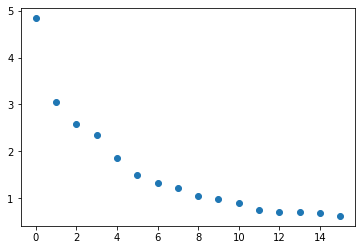

In [96]:
plt.scatter(range(16),np.log10(σ[0:16]))

In [97]:
#get first 5 modes of K
mode1= np.reshape(U[:,0],(krat.shape[0],1))*sigma[0,0]* np.reshape(VH[0,:], (1,krat.shape[1]))
mode2= np.reshape(U[:,1],(krat.shape[0],1))*sigma[1,1]* np.reshape(VH[1,:], (1,krat.shape[1]))
mode3= np.reshape(U[:,2],(krat.shape[0],1))*sigma[2,2]* np.reshape(VH[2,:], (1,krat.shape[1]))
mode4= np.reshape(U[:,3],(krat.shape[0],1))*sigma[3,3]* np.reshape(VH[3,:], (1,krat.shape[1]))
mode5= np.reshape(U[:,4],(krat.shape[0],1))*sigma[4,4]* np.reshape(VH[4,:], (1,krat.shape[1]))

Text(0, 0.5, 'Mode 1 of Calibration Parameter K')

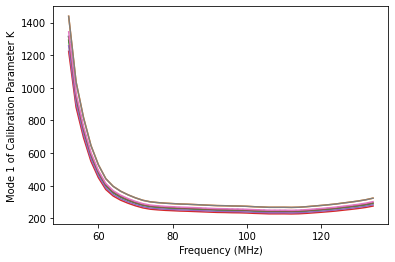

In [98]:
plt.plot(x, np.mean(mode1, axis=0),lw = 2, ls=':')
plt.plot(x, mode1[0,:])
plt.plot(x, mode1[200,:])
plt.plot(x, mode1[300,:])
plt.plot(x, mode1[400,:])
plt.plot(x, mode1[500,:])
plt.plot(x, mode1[600,:])
plt.plot(x, mode1[719,:])
plt.xlabel('Frequency (MHz)')
plt.ylabel('Mode 1 of Calibration Parameter K')
#plt.legend(loc = 'upper right', prop ={'size': 12})

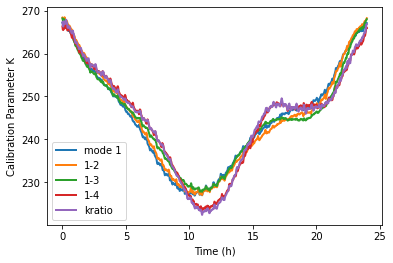

In [99]:
i = 30
plt.plot(lst_2min, mode1[:, i], lw = 2, label='mode 1')
plt.plot(lst_2min, mode1[:, i] + mode2[:, 30], lw = 2, label='1-2')
plt.plot(lst_2min, mode1[:, i] + mode2[:, 30] + mode3[:,30], lw = 2, label='1-3')
plt.plot(lst_2min, mode1[:, i] + mode2[:, 30] + mode3[:,30] + mode4[:,30], lw = 2, label='1-4')
plt.plot(lst_2min, krat[:, i], lw = 2, label='kratio')
#plt.plot(mode1[:,10],lw = 2, ls = ":")
#plt.plot(mode1[:,20],lw = 2, ls = ":")
plt.xlabel('Time (h)')
plt.ylabel('Calibration Parameter K')
plt.legend()

## Fit

T_sky computed at this 

In [100]:
observed = (mode1+mode2) * data_binned[:,::2]
obs=np.nanmean(observed, axis=0)
# obs = observed[500]

poly=3
fit = np.polyfit(np.log10(x/100), np.log10(obs), poly)    
power = np.zeros(len(x))
i = 0
while i <= poly:
    power = power + fit[poly-i]*(np.log10(x/100))**i
    i += 1
y_3 = 10**(power)

poly=6
fit = np.polyfit(np.log10(x/100), np.log10(obs), poly)    
power = np.zeros(len(x))
i = 0
while i <= poly:
    power = power + fit[poly-i]*(np.log10(x/100))**i
    i += 1
y_6 = 10**(power)

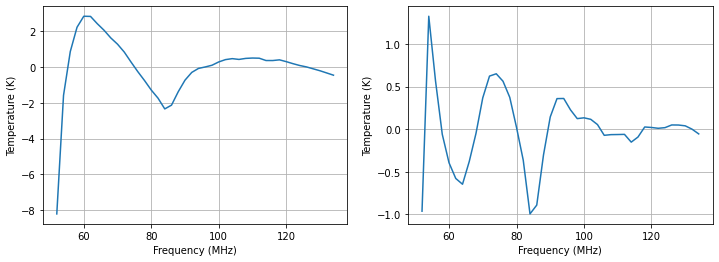

In [101]:
fig = plt.figure(figsize=(12,4))
ax = fig.subplots(1,2)

ax[0].grid()
# ax[0].set_ylim(-10,10)
ax[0].plot(x, obs - y_3)
ax[0].set_ylabel('Temperature (K)')
ax[0].set_xlabel('Frequency (MHz)')

ax[1].grid()
# ax[1].set_ylim(-2,2)
ax[1].plot(x, obs - y_6)
ax[1].set_ylabel('Temperature (K)')
ax[1].set_xlabel('Frequency (MHz)')
plt.show()

### Individual days

In [22]:
days = hf.split_days(lst)

In [50]:
y6_1day = []
obs_1day = []
for i in range(len(days)-1):
    data_binned_day, _, _, _, _ = hf.binning(data[days[i]:days[i+1]], freq, lst[days[i]:days[i+1]], binsize_f, binsize_t, flow, fhigh)
    krat = Tgsm_c / data_binned_day[:, ::2]
    
    #get first 5 modes of K
    mode1= np.reshape(U[:,0],(krat.shape[0],1))*sigma[0,0]* np.reshape(VH[0,:], (1,krat.shape[1]))
    mode2= np.reshape(U[:,1],(krat.shape[0],1))*sigma[1,1]* np.reshape(VH[1,:], (1,krat.shape[1]))
    mode3= np.reshape(U[:,2],(krat.shape[0],1))*sigma[2,2]* np.reshape(VH[2,:], (1,krat.shape[1]))
    mode4= np.reshape(U[:,3],(krat.shape[0],1))*sigma[3,3]* np.reshape(VH[3,:], (1,krat.shape[1]))
    mode5= np.reshape(U[:,4],(krat.shape[0],1))*sigma[4,4]* np.reshape(VH[4,:], (1,krat.shape[1]))
    
    observed = (mode1) * data_binned_day[:,::2]
    obs=np.nanmean(observed, axis=0)
    # obs = observed[500]

    poly=6
    fit = np.polyfit(np.log10(x/100), np.log10(obs), poly)    
    power = np.zeros(len(x))
    i = 0
    while i <= poly:
        power = power + fit[poly-i]*(np.log10(x/100))**i
        i += 1
    y6_1day.append(10**(power))
    obs_1day.append(obs)


/gpfs/fs0/scratch/s/sievers/nasuyu/PRIZM/prizm-analysis/helper_functions.py:63: RuntimeWarning: Mean of empty slice
  data_binned = np.array([[np.nanmean(data[bin_inds_t == i][:, bin_inds_f == j]) \
/tmp/ipykernel_185677/1127994327.py:16: RuntimeWarning: Mean of empty slice
  obs=np.nanmean(observed, axis=0)


In [ ]:
plt.plot(x, obs_1day[3] - y6_1day[3])

Text(0.5, 0, 'Frequency (MHz)')

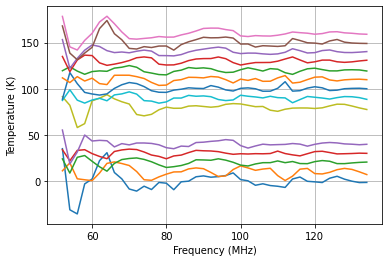

In [51]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.grid()
# ax.set_ylim(-10,100)
# for i in range(1,14):
for i in range(len(y6_1day) - 1):
    ax.plot(x, 10*i + obs_1day[i] - y6_1day[i])
ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Frequency (MHz)')

Text(0.5, 0, 'Frequency (MHz)')

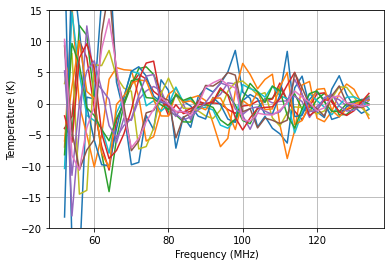

In [30]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.grid()
ax.set_ylim(-20,15)
for i in range(len(y6_1day) - 1):
    ax.plot(x, obs_1day[i] - y6_1day[i])
ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Frequency (MHz)')